__<h3>Author: IDIKA, UDUMA UDUMA</h3>__

__<h3>Major: Data Management and Artificial Intelligence</h3>__

__<h3>Topic: Building a Neural Network from Scratch using JAX</h3>__

__<h3>Objective:</h3>__

**Development of a Two-Layer Classification Neural Network from Scratch using JAX.**

I achieved this via the following steps:

Step 1: Defining the Neural Network Architecture  
Step 2: Initializing Weights and Biases <br>
Step 3: Implementing the Forward Pass <br>
Step 4: Defining the Loss Function <br>
Step 5: Implementing the Backpropagation Algorithm <br>
Step 6: Updating Model Parameters (Weights and Biases) using Gradient Descent <br>
Step 7: Training Loop Implementation <br>
Step 8: Evaluating Model Performance <br>
Step 9: Evaluating Model Accuracy on Test Set <br>

In addition, I developed a **Gaussian Basis function** as a function approximation model for features transformation 
before feeding the features through a neural network architecture.


In [5]:
#Importing the necessary libraries
import jax
import jax.numpy as jnp
from jax import grad
import jax.random as random
import matplotlib.pyplot as plt


from sklearn.datasets import load_breast_cancer   #Dataset to be used

from sklearn.model_selection import train_test_split

**<h3>Part A: Development of a Gaussian Basis Function for Features Transformation</h3>**

In [7]:
#Step 1: Understanding and Defining the Breast Cancer Wisconsin Dataset

#The Breast Cancer Wisconsin Dataset contains 30 numerical features that describes tumor characteristics and a binary target that indicates whether the tumor is malignant or benign

#Features:
# - 30 numerical features
# - Each represents a tumor characteristic derived from a digitized image of a fine needle aspirate (FNA) biopsy of a breast mass.

#The target is a binary target
# 0 - malignant (cancerous)
# 1 - benign (non-cancerous)

# Load the Breast Cancer Wisconsin Dataset
wisconsin_data = load_breast_cancer()

x_wisconsin = wisconsin_data.data       #Features
y_wisconsin = wisconsin_data.target

#Splitting the data into train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_wisconsin, y_wisconsin, test_size = 0.3, random_state=42)

#Step 2:
#Generating the Gaussian Features

# First, determine the number of Gaussian centres using the rule of thumb of sqrt(N)
num_centres = int(round(jnp.sqrt(x_wisconsin.shape[0])))  #Ensuring it is a whole number
print(f"Number of mu centres: {num_centres}\n")

def mu_values(x):
    min_value = x.min()
    max_value = x.max()
    return jnp.linspace(min_value, max_value, num_centres)

#Determining the spread(width), sigma
sigma = jnp.mean(jnp.diff(mu_values(x_wisconsin)))
    
def gaussian_function(x, mu, sigma):
    # Returning the Gaussian feature
    return jnp.exp(-(x-mu)**2/(2*sigma))

x_gaussian_train = jnp.column_stack([gaussian_function(x_train, mu, sigma) for mu in mu_values(x_train)])
x_gaussian_test = jnp.column_stack([gaussian_function(x_test, mu, sigma) for mu in mu_values(x_test)])

print(f"Shape of train set: {x_gaussian_train.shape}")
print(f"Shape of test set: {x_gaussian_test.shape}")

Number of mu centres: 24

Shape of train set: (398, 720)
Shape of test set: (171, 720)


**<h3>Part B: Development of a Neural Network Model</h3>**

**Note: This Neural Network Implementation is for a 2-layer neural network**

In [10]:
#Step 1:
#Define an initialization function for the weights

def initialization_fn(key, shape):
        return random.normal(key, shape) * jnp.sqrt(2/shape[0])   #He initialization for ReLU activation

class NeuralNetwork:
    
    def __init__(self, key, input_dim, hidden_dim, output_dim):
        #Define the parameters of the network
        key1, key2 = random.split(key, num=2)
        
        self.W1 = initialization_fn(key1, (input_dim, hidden_dim))
        self.b1 = jnp.zeros(hidden_dim,)                                #biases are initialized to zero

        self.W2 = initialization_fn(key2, (hidden_dim, output_dim))
        self.b2 = jnp.zeros(output_dim,)


    def forward_pass(self, x):
        z1 = jnp.dot(x, self.W1) + self.b1     #pre-activation of the hidden layer
        h = jax.nn.relu(z1)                    #applying ReLU activation for the hidden layer

        z2 = jnp.dot(h, self.W2) + self.b2     #pre-activation of the output layer
        y_pred = jax.nn.softmax(z2)            #applying Softmax to get the probabilities of the predicted target

        return y_pred

x = x_gaussian_train
y = y_train

#Creating an instance of the NeuralNetwork class
main_key = random.PRNGKey(42)
input_dim = x.shape[1]
hidden_dim = 500                              #Numboer of neurons in the hidden layer
output_dim = jnp.unique(y_wisconsin).size         #Number of neurons in the output layer corresponds to the number of distinct classes in the target

nn = NeuralNetwork(key=main_key, input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)  #The _dim here refers to the number of neurons in each layer

#Wrapping the parameters in a "params" dictionary
params = {
    "W1": nn.W1,
    "b1": nn.b1,
    "W2": nn.W2,
    "b2": nn.b2
}


# Convert the target to One-Hot Encoding to obtain y_true
num_classes = jnp.unique(y_wisconsin).size
y_true = jnp.eye(num_classes)[y_train]

#Determine initial y_pred from the initial weights and bias initialization
y_pred = nn.forward_pass(x)

#Printing the shapes of the model's parameters
print("\nModel Architecture:")
for k,v in params.items():
    print(f"{k}: {v.shape}")


#Defining the loss function (cross-entropy)
def cross_entropy_loss(y_true, y_pred):
    return -jnp.mean(jnp.sum(y_true * jnp.log(y_pred + 1e-8), axis=1))   #Added 1e-8 to avoid log(0) that causes instability

#Defining the loss function wrapper to compute the gradient using the loss function
def loss_func(params, x, y_true):
    W1, b1, W2, b2 = params["W1"], params["b1"], params["W2"], params["b2"]
    
    z1 = jnp.dot(x, W1) + b1     #pre-activation of the hidden layer
    h = jax.nn.relu(z1)          #applying ReLU activation for the hidden layer

    z2 = jnp.dot(h, W2) + b2     #pre-activation of the output layer
    y_pred = jax.nn.softmax(z2)
    
    return cross_entropy_loss(y_true, y_pred)

#Automatically determining the gradients during backpropagation
grads = grad(loss_func)(params, x, y_true)

#Printing the initial values of the Model's parameters (params)
print("\nInitial Model Parameters:")
for k, v in params.items():
    print(f"{k}: {v}\n")


Model Architecture:
W1: (720, 500)
b1: (500,)
W2: (500, 2)
b2: (2,)

Initial Model Parameters:
W1: [[ 0.03801295 -0.00787694  0.02042713 ...  0.05356743 -0.07715157
   0.0164176 ]
 [-0.02737028  0.00179507  0.04536506 ... -0.03040226 -0.00200438
   0.05623063]
 [ 0.00792097 -0.12584849 -0.04708342 ... -0.05605217 -0.00094703
  -0.05915146]
 ...
 [ 0.0553728   0.01802494  0.04644481 ...  0.00814191  0.03396561
   0.12907237]
 [-0.00419481  0.09839587  0.08693402 ...  0.04947737 -0.01032405
   0.00153391]
 [ 0.05252995  0.12456809 -0.07527254 ...  0.03815395 -0.02178069
   0.01605911]]

b1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

**<h3>Model Parameters (Weights & Biases) Update using Gradient Descent  </h3>**

In [12]:
#Since JAX is designed for functional programming, 
#we will return updated parameters instead of modifying parameters in place

learning_rate=0.04

def update_params(params, gradients, learning_rate):
    """
    Performs a gradient descent update on the neural network parameters.
    
    Arguments:
    - params: Dictionary containing the initial model parameters (W1, b1, W2, b2).
    - gradients: Gradient function output from JAX, same structure as params.
    - learning_rate: Step size for parameter updates.
    
    Returns:
    - Updated parameters.
    """
    updated_params = jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, gradients)
    return updated_params

#Testing the function using our existing sample data

updated_params = update_params(params, grads, learning_rate)

#Printing the initial values of the Model's parameters (params)
print("Initial Model Parameters:")
for k, v in params.items():
    print(f"{k}: {v}\n")

#Printing the values of the model's updated_parameters
print("\nUpdated Model Parameters:")
for k, v in updated_params.items():
    print(f"{k}: {v}\n")

Initial Model Parameters:
W1: [[ 0.03801295 -0.00787694  0.02042713 ...  0.05356743 -0.07715157
   0.0164176 ]
 [-0.02737028  0.00179507  0.04536506 ... -0.03040226 -0.00200438
   0.05623063]
 [ 0.00792097 -0.12584849 -0.04708342 ... -0.05605217 -0.00094703
  -0.05915146]
 ...
 [ 0.0553728   0.01802494  0.04644481 ...  0.00814191  0.03396561
   0.12907237]
 [-0.00419481  0.09839587  0.08693402 ...  0.04947737 -0.01032405
   0.00153391]
 [ 0.05252995  0.12456809 -0.07527254 ...  0.03815395 -0.02178069
   0.01605911]]

b1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

**<h3>Training Loop Implementation</h3>**

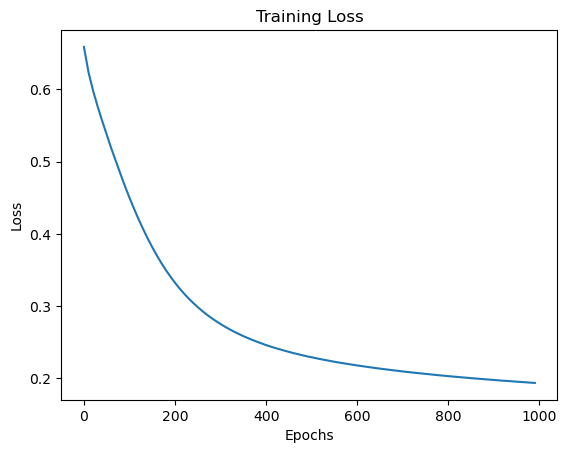

In [14]:
#This entails structuring our training process to iteratively update the parameters over multiple epochs
epochs = 1000
def train_model(params, x_train, y_train, epochs, learning_rate):
    """
    Trains the neural network using gradient descent.

    Arguments:
    - params: Dictionary of initial model parameters.
    - x_train: Input training data.
    - y_train: True labels (one-hot encoded).
    - epochs: Number of iterations for training.
    - learning_rate: Step size for gradient descent.

    Returns:
    - params: Trained parameters after `epochs` iterations.
    - epoch_list: A list that contains some specified epochs
    - loss_list: A list that contains the loss for for the specified epochs
    """
    epoch_list = []
    loss_list = []
    
    for epoch in range(epochs):
        #Compute gradients
        grads = grad(loss_func)(params, x_train, y_train)

        #Update parameters
        params = update_params(params, grads, learning_rate)

        #Compute loss after 10 epochs for monitoring
        if epoch % 10 == 0:
            loss = loss_func(params, x_train, y_train)
            #print(f"Epoch {epoch}: Loss = {loss:.4f}")

            loss_value = float(loss)
            epoch_list.append(epoch)
            loss_list.append(round(loss_value, 4))

    return params, epoch_list, loss_list
        
#Testing the training loop
x_train = x.copy()
y_train = y_true.copy()

final_params, epoch_list, loss_list = train_model(params, x_train, y_train, epochs, learning_rate)

#Printing the final model parameters
#print(f"\nFinal Model Parameters:")
#for k, v in final_params.items():
    #print(f"{k}: {v}\n")

#Visualizing the loss over the epoch
import matplotlib.pyplot as plt

#print(loss_list)
#print(epoch_list)
plt.plot(epoch_list, loss_list)
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show();

**<h3>Evaluating Model Performance </h3>**

In [16]:
#Compute the final loss of the model
final_loss = loss_func(final_params, x_train, y_train)
print(f"Final Loss: {final_loss:.4f}")

#Implementing a predict function to make predictions using the final_params
def predict(params, x):
    z1 = jnp.dot(x, params["W1"]) + params["b1"]
    h = jax.nn.relu(z1)

    z2 = jnp.dot(h, params["W2"]) + params["b2"]
    y_pred = jax.nn.softmax(z2)
    return y_pred

#Prediction on training data
y_pred = predict(final_params, x_train)
print(f"\nPredicted Values:\n{y_pred}")

#Evaluating Model Performance
def compute_accuracy(y_pred, y_true):
    """Compute accuracy by comparing predicted and actual labels"""
    predicted_labels = jnp.argmax(y_pred, axis=1)  #Getting the class with the highest probability
    actual_labels = jnp.argmax(y_true, axis=1)     #Getting the actual class labels
    accuracy = jnp.mean(predicted_labels == actual_labels)
    return accuracy

Final Loss: 0.1931

Predicted Values:
[[1.63588434e-01 8.36411595e-01]
 [8.51973332e-03 9.91480231e-01]
 [2.12202355e-01 7.87797630e-01]
 [1.69483982e-02 9.83051538e-01]
 [6.41289830e-01 3.58710229e-01]
 [9.82729793e-01 1.72701571e-02]
 [7.05520734e-02 9.29447949e-01]
 [3.22580859e-02 9.67741966e-01]
 [1.15805991e-01 8.84193957e-01]
 [2.02878848e-01 7.97121167e-01]
 [2.47448832e-02 9.75255132e-01]
 [4.05880914e-04 9.99594152e-01]
 [8.34990561e-01 1.65009424e-01]
 [9.18746948e-01 8.12530071e-02]
 [6.85096681e-01 3.14903319e-01]
 [5.71088612e-01 4.28911388e-01]
 [3.27721052e-02 9.67227876e-01]
 [8.23757529e-01 1.76242411e-01]
 [4.45330501e-01 5.54669559e-01]
 [9.92550254e-01 7.44976569e-03]
 [1.20844645e-02 9.87915516e-01]
 [5.09120002e-02 9.49087977e-01]
 [8.46749768e-02 9.15325046e-01]
 [3.12240664e-02 9.68775988e-01]
 [9.55311537e-01 4.46884632e-02]
 [1.49162248e-01 8.50837708e-01]
 [1.01616082e-03 9.98983800e-01]
 [9.60307300e-01 3.96927148e-02]
 [7.24888453e-03 9.92751122e-01]
 [2.6

In [17]:
#Computing the training accuracy
accuracy = compute_accuracy(y_pred, y_train)
print(f"\nTraining Accuracy: {accuracy * 100:.2f}%")


Training Accuracy: 92.21%


**<h3>Evaluating Model Accuracy on the Test Set</h3>**

In [19]:
#Prediction on test data
y_pred_test = predict(final_params, x_gaussian_test)

y_true_test = jnp.eye(num_classes)[y_test]   #One-hot encoded values of the y_test

#Computing the test accuracy
accuracy_test = compute_accuracy(y_pred_test, y_true_test)
print(f"\nTesting Accuracy: {accuracy_test * 100:.2f}%")


Testing Accuracy: 94.15%
